In [6]:
import torch
from architecture import GPTModel
from dataclasses import dataclass

@dataclass
class GPTConfig:
    vocab_size: int = 50257
    context_length: int = 256
    em_dim: int = 768
    n_heads: int = 12
    n_layers: int = 12
    drop_rate: float = 0.1
    qkv_bias: bool = False

GPT_CONFIG_124M = GPTConfig()
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_embs): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForwardNetwork(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query)

In [7]:
import tiktoken

def generate_text_simple(model, idx, max_new_tokens, context_size):

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]  # focus on last time step
        probabs = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probabs, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded, dtype=torch.long).unsqueeze(0)
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M.context_length,
)
print("Generated text:\n", token_ids_to_text(token_ids, tokenizer))

Generated text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [8]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as f:
    raw_text = f.read()

total_characters = len(raw_text)
total_tokens = len(tokenizer.encode(raw_text))
print(f"Total characters in Naval Ravikant text: {total_characters}")
print(f"Total tokens in Naval Ravikant text: {total_tokens}")

Total characters in Naval Ravikant text: 20479
Total tokens in Naval Ravikant text: 5145


In [9]:
train_ratio = 0.9
split_idx = int(len(raw_text) * train_ratio)
train_data = raw_text[:split_idx]
val_data = raw_text[split_idx:]

In [10]:
import torch
import tiktoken
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of 
        # max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size, max_length, stride,
                         shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, 
        num_workers=num_workers)

    return dataloader


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    txt=train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M.context_length,
    stride=GPT_CONFIG_124M.context_length,
    drop_last=True,
    shuffle=True,
    num_workers=0,
)

val_loader = create_dataloader_v1(
    txt=val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M.context_length,
    stride=GPT_CONFIG_124M.context_length,
    drop_last=False,
    shuffle=False,
    num_workers=0,
)

print("Train loader")
for x, y in train_loader:
    print(x.shape, y.shape)

print("Validation loader")
for x, y in val_loader:
    print(x.shape, y.shape)


Train loader
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
Validation loader
torch.Size([2, 256]) torch.Size([2, 256])


In [11]:
# cross entropy loss function

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0,1), target_batch.flatten()
    )
    return loss 


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    
    return total_loss / num_batches

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print(f"Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}")

Train loss: 10.9876, Validation loss: 10.9811


In [15]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(mode, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size,
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print("Generated text:\n", decoded_text)
    model.train()


def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_steps = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_steps += 1

            if global_steps % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch+1}, Step {global_steps}: \n"
                    f"Train loss: {train_loss:.4f}, Val Loss = {val_loss:.4f}")
                
        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.1)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context=start_context,
    tokenizer=tokenizer,
)


Epoch 1, Step 0: 
Train loss: 9.9229, Val Loss = 10.0632
Epoch 1, Step 5: 
Train loss: 8.4352, Val Loss = 8.6530
Generated text:
 Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Epoch 2, Step 10: 
Train loss: 7.1425, Val Loss = 7.4894
Epoch 2, Step 15: 
Train loss: 6.2367, Val Loss = 6.8130
Generated text:
 Every effort moves you, and, and, and, and, and, and, and, and,, and,, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Epoch 3, Step 20: 
Train loss: 5.8652, Val Loss = 6.5411
Epoch 3, Step 25: 
Train loss: 5.3603, Val Loss = 6.3438
Generated text:
 Every effort moves you, and I had














































Epoch 4, Step 30: 
Train loss: 5.1669, Val Loss = 6.4355
Epoch 4, Step 35: 
Train loss: 4.6938, Val Loss = 6.2862
Generated text:
 Every effort moves you, and, and I was a of the picture, I had been.



































Epoch 5, Step 40: 
Train loss: 4.2687, Val Loss = 6.1691
Generated text:
 Ever

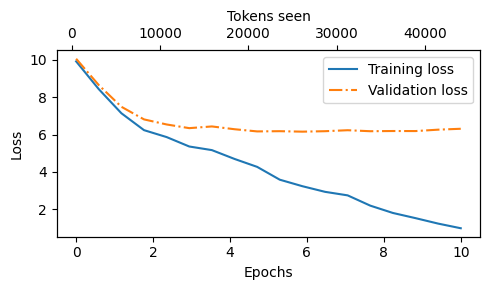

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_loss, val_loss):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()                   #1
    ax2.plot(tokens_seen, train_losses, alpha=0)     #2
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

# model is overfitting the training data, since we are working with a small dataset, and training the model for many epochs.
# To mitigate overfitting, we can consider techniques such as using a larger dataset.

## Text Generation (decoding) Strategy
#### temperature scaling and top-k sampling

In [19]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M.context_length,
)
print("Generated text:\n", token_ids_to_text(token_ids, tokenizer))

# gneerated text remains consistent , corresponding to the largest probability score. basically greedy decoding.

Generated text:
 Every effort moves you know," was one of the axioms he had been the frame called up all Gisburn's past!




In [ ]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

In [26]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]  # focus on last time step

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        
        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)
    
    return idx

torch.manual_seed(123)
token_ids = generate(
    model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M.context_length,
    temperature=1.3,
    top_k=25
)
print("Generated text:\n", token_ids_to_text(token_ids, tokenizer))

Generated text:
 Every effort moves you not to work on surprise, a picture to have been the end by by


### Loading pretrained weights from OpenAI GPT-2 model

In [2]:
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow>=2.15.0", "tqdm>=4.66"])

0

In [4]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
    model_size="124M", models_dir="gpt2"
)

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 128kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:02<00:00, 465kiB/s] 
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 50.4kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [23:44<00:00, 349kiB/s]    
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 3.16MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 269kiB/s]  
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 235kiB/s]  
